<a href="https://colab.research.google.com/github/MunySafitri/Pemrosesan-Citra-Digital/blob/main/Finish_PCD_Assignment1_Muny_Safitri.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [132]:
from PIL import Image
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from google.colab.patches import cv2_imshow
%matplotlib inline

#Gray Scale dan Histogram

##Membaca gambar

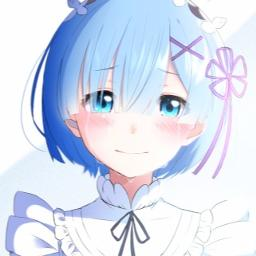

In [133]:
image = cv.imread('/content/drive/MyDrive/Colab Notebooks/img/asal.jpg')
cv2_imshow(image)

##Konversi ke gray Scale

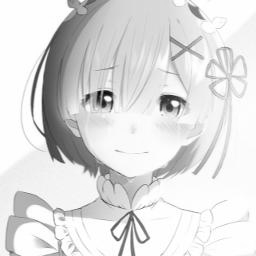

In [134]:
image = cv.cvtColor(image,cv.COLOR_BGR2GRAY)
cv2_imshow(image)

##Membuat Histogram


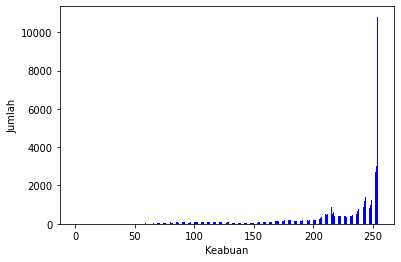

In [135]:
# NO 1 (HISTOGRAM DARI IMAGE) 
grayimg = image.astype(int)
keabuan = np.zeros(256,dtype=int)
r = np.zeros(256,dtype=int)
#dilakukan looping hingga L-1 dimana L adalah jumlah warna pada gray scale (untuk sumbu x)
for x in range (256):
    r[x] = x
tinggi, lebar = grayimg.shape
#mengukur jumlah pixel
n = tinggi*lebar 
#melakukan looping untuk melakukan perhitungan frekuensi (setiap index keabuan untuk sumbu y)
for i in range(tinggi):
    for j in range (lebar):
        keabuan[ grayimg[i,j] ] += 1
plt.xlabel('Keabuan')
plt.ylabel('Jumlah')
plt.bar(r, keabuan,color ='blue', width = 0.5)
plt.show()

#Non Uniform Equalization - Max Lloyd

##Fungsi atau Rumus yang dibutuhkan

In [136]:
import numpy as np
import scipy.integrate as integrate

In [137]:
#fungsi distribusi normal dibuat dengan scipy.integral.quad
def normal_dist(x, mean=0.0, vari=1.0):
    return (1.0/(np.sqrt(2.0*np.pi*vari)))*np.exp((-np.power((x-mean),2.0))/(2.0*vari))


In [138]:
#fungsi nilai yang diharapkan distribusi normal dibuat dengan scipy. integral.quad
def expected_normal_dist(x, mean=0.0, vari=1.0):
    return (x/(np.sqrt(2.0*np.pi*vari)))*np.exp((-np.power((x-mean),2.0))/(2.0*vari))


In [139]:
def laplace_dist(x, mean=0.0, vari=1.0):
    #distribusi laplace beta digunakan untuk mengganti variance, jadi konversi nilai diperlukan
    scale = np.sqrt(vari/2.0)
    return (1.0/(2.0*scale))*np.exp(-(np.abs(x-mean))/(scale))


In [140]:
#
def expected_laplace_dist(x, mean=0.0, vari=1.0):
    scale = np.sqrt(vari/2.0)
    return x*(1.0/(2.0*scale))*np.exp(-(np.abs(x-mean))/(scale))

#def variance(x, mean=0.0, std=1.0):
#    """
#    create normal distribution 
#    """
#    return (1.0/(std*np.sqrt(2.0*np.pi)))*np.power(x-mean,2)*np.exp((-np.power((x-mean),2.0)/(2.0*np.power(std,2.0))))


In [141]:
""" 
menemukan nilai MSE antara x (citra asli) dan x_hat (citra dikuantisasi)
  x: citra tanpa quantization
  x_hat_q: citra x serelah quantization
return:
  MSE :Mean Square Loss antara x dan x_hat_q
"""
def MSE_loss(x, x_hat_q):
    x = np.array(x)
    x_hat_q = np.array(x_hat_q)
    # if a condition in your code returns True, if not, the program will raise an AssertionError.
    assert np.size(x) == np.size(x_hat_q)
    MSE = np.sum(np.power(x-x_hat_q,2))/np.size(x)
    return MSE


## LloydMaxQuantizer

In [142]:
class LloydMaxQuantizer(object):

    """
    class untuk interasi Lloyd Max quantizer
    quantizer ini dibuat untuk meminimalisir perhitungan SNR () antara citra asli dan citra di kuantisasi
    This quantizer is created to minimize amount SNR between the orginal signal
    
    The proposed algorithm is applied on the standard
    test images from the USC-SIPI Image Database
    (sipi.usc.edu/database). Peak Signal to Noise Ratio
    (PSNR) and Mean Structural Similarity Index Measure (MSSIM) (Wang et al., 2004) are used to evaluate the quality of reconstructed images.
    """
    @staticmethod
    def start_repre(x, bit):
        """
        hasilkan representasi dari setiap threshold menggunakan
          x: input image
          bit:jumlah bit
        return:
          threshold
        """
        assert isinstance(bit, int)
        x = np.array(x)
        num_repre  = np.power(2,bit)
        step = (np.max(x)-np.min(x))/num_repre
        
        middle_point = np.mean(x)
        repre = np.array([])
        for i in range(int(num_repre/2)):
             repre = np.append(repre, middle_point+(i+1)*step)
             repre = np.insert(repre, 0, middle_point-(i+1)*step)
        return repre

    @staticmethod
    def threshold(repre):
        """
        """
        t_q = np.zeros(np.size(repre)-1)
        for i in range(len(repre)-1):
            t_q[i] = 0.5*(repre[i]+repre[i+1])
        return t_q
    
    @staticmethod
    def represent(thre, expected_dist, dist):
        """
        """
        thre = np.array(thre)
        x_hat_q = np.zeros(np.size(thre)+1)
        #prepare for all possible integration range
        thre = np.append(thre, np.inf)
        thre = np.insert(thre, 0, -np.inf)
    
        for i in range(len(thre)-1):
             x_hat_q[i] = integrate.quad(expected_dist, thre[i], thre[i+1])[0]/(integrate.quad(dist,thre[i],thre[i+1])[0])
        return x_hat_q
    
    @staticmethod
    def quant(x, thre, repre):
        """Quantization operation. 
        """
        thre = np.append(thre, np.inf)
        thre = np.insert(thre, 0, -np.inf)
        x_hat_q = np.zeros(np.shape(x))
        for i in range(len(thre)-1):
            if i == 0:
                x_hat_q = np.where(np.logical_and(x > thre[i], x <= thre[i+1]),
                                   np.full(np.size(x_hat_q), repre[i]), x_hat_q)
            elif i == range(len(thre))[-1]-1:
                x_hat_q = np.where(np.logical_and(x > thre[i], x <= thre[i+1]), 
                                   np.full(np.size(x_hat_q), repre[i]), x_hat_q)
            else:
                x_hat_q = np.where(np.logical_and(x > thre[i], x < thre[i+1]), 
                                   np.full(np.size(x_hat_q), repre[i]), x_hat_q)
        return x_hat_q

In [143]:
try: import matplotlib.pyplot as plt
except ModuleNotFoundError:
    import matplotlib
    matplotlib.use('agg')
    import matplotlib.pyplot as plt
import numpy as np
import argparse, os

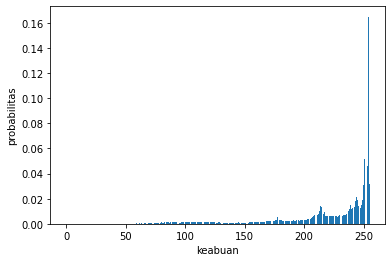

In [144]:
#pr =probability, melakukan normalisasi,
#konversi nilai frekuensi keabuan menjadi nilai lebih kecil
pr = keabuan/n
plt.xlabel('keabuan')
plt.ylabel('probabilitas')
plt.bar(r, pr)
plt.show()


In [145]:
# print(type(pr))
#berupa nilai array
x = pr
# print(pr)
repre = LloydMaxQuantizer.start_repre(x, 4) #4 bit, quantitazion level
min_loss = 1.0 #tentukan nilai minimum loss 

In [146]:
for i in range(100):
        thre = LloydMaxQuantizer.threshold(repre)
        #In case wanting to use with another mean or variance, need to change mean and variance in untils.py file
        repre = LloydMaxQuantizer.represent(thre, expected_normal_dist, normal_dist)
        x_hat_q = LloydMaxQuantizer.quant(x, thre, repre)
        loss = MSE_loss(x, x_hat_q)

        # Print every 10 loops
        # if(i%10 == 0 and i != 0):
        #     print('iteration: ' + str(i))
        #     print('thre: ' + str(thre))
        #     print('repre: ' + str(repre))
        #     print('loss: ' + str(loss))
        #     print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')

        # Tetapkan threshold sampaikan punya nilai MSE loss terkecil 
        if(min_loss > loss):
            min_loss = loss
            min_thre = thre
            min_repre = repre

In [147]:
print('min loss' + str(min_loss))
print('min thre' + str(min_thre))
print('min repre' + str(min_repre))

min loss1.54497268569118e-05
min thre[-0.84411909 -0.25777576 -0.07630111 -0.04249698 -0.0321046  -0.02122883
 -0.00922526  0.00390607  0.01703743  0.02904108  0.03991689  0.05030927
  0.08401714  0.26486692  0.84963259]
min repre[-1.40176173 -0.5353695  -0.16658052 -0.05939339 -0.03730046 -0.02666645
 -0.01522686 -0.00265956  0.0104716   0.02303898  0.03447864  0.04511267
  0.06715685  0.1739671   0.54157781  1.4060735 ]


##Hasil Histogram 

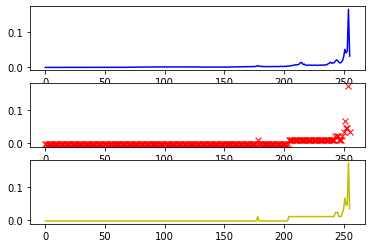

In [148]:
#x_hat_q adalah citra dengan jumlah loss paling rendah
#x adalah nilai citra
best_x_hat_q = LloydMaxQuantizer.quant(x, min_thre, min_repre)
fig = plt.figure()
ax = fig.add_subplot(3,1,1)
ax.plot(range(np.size(x)), x, 'b')
ax = fig.add_subplot(3,1,2)
ax.plot(range(np.size(best_x_hat_q)), best_x_hat_q, 'rx')
ax = fig.add_subplot(3,1,3)
ax.plot(range(np.size(best_x_hat_q)), best_x_hat_q, 'y')
plt.show()

In [149]:
print(best_x_hat_q )

[-0.00265956 -0.00265956 -0.00265956 -0.00265956 -0.00265956 -0.00265956
 -0.00265956 -0.00265956 -0.00265956 -0.00265956 -0.00265956 -0.00265956
 -0.00265956 -0.00265956 -0.00265956 -0.00265956 -0.00265956 -0.00265956
 -0.00265956 -0.00265956 -0.00265956 -0.00265956 -0.00265956 -0.00265956
 -0.00265956 -0.00265956 -0.00265956 -0.00265956 -0.00265956 -0.00265956
 -0.00265956 -0.00265956 -0.00265956 -0.00265956 -0.00265956 -0.00265956
 -0.00265956 -0.00265956 -0.00265956 -0.00265956 -0.00265956 -0.00265956
 -0.00265956 -0.00265956 -0.00265956 -0.00265956 -0.00265956 -0.00265956
 -0.00265956 -0.00265956 -0.00265956 -0.00265956 -0.00265956 -0.00265956
 -0.00265956 -0.00265956 -0.00265956 -0.00265956 -0.00265956 -0.00265956
 -0.00265956 -0.00265956 -0.00265956 -0.00265956 -0.00265956 -0.00265956
 -0.00265956 -0.00265956 -0.00265956 -0.00265956 -0.00265956 -0.00265956
 -0.00265956 -0.00265956 -0.00265956 -0.00265956 -0.00265956 -0.00265956
 -0.00265956 -0.00265956 -0.00265956 -0.00265956 -0

##Hasil Citra

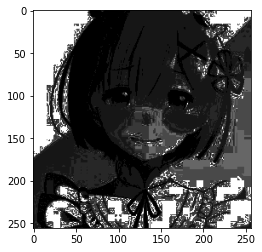

In [150]:
result = np.zeros(grayimg.shape, dtype=int)
best_x_hat_q = best_x_hat_q*255 #mengmablikan nilai range 0-1 disetiap best_x_hat_q menjadi nilai range 0-255
tinggi, lebar = grayimg.shape
n = tinggi*lebar
for i in range (tinggi):
    for j in range (lebar):
        result[i,j] = round (best_x_hat_q[grayimg[i,j]]) #mengganti nilai setiap pixel hasil dari best_x_hat_q 
plt.imshow(result, cmap = 'gray')